Paper: https://arxiv.org/abs/1505.04597

In [2]:
!pip -q install torchinfo
!pip -q install torchview

In [3]:
import torch
from torch import nn
import torchvision.transforms.functional as TF

from torchinfo import summary
from torchview import draw_graph

from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision

In [4]:
import os
import glob

from sklearn.model_selection import train_test_split

from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from tqdm import tqdm

# Downloa Dataset from Kaggel

In [5]:
# 1. Read the kaggle API token to interact with your kaggle account
from google.colab import files
files.upload()

#2. Series of commands to set-up for download
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory

#3. giving rw access (if 401-nathorized)
!chmod 600 ~/.kaggle/kaggle.json

#4. Sanity check if able to access kaggle
# !kaggle datasets list

#5. Download data command
!kaggle datasets download -d "nikhilroxtomar/person-segmentation" -p /content/dataset
# for example: !kaggle datasets download -d thedevastator/hubmap-2022-512x512 -p < /content/drive/MyDrive/Task2_hubmap

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 67 Jan 26 18:50 kaggle.json
/content
Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/person-segmentation
License(s): unknown
 94% 432M/461M [00:01<00:00, 345MB/s]
100% 461M/461M [00:01<00:00, 375MB/s]


In [6]:
#6. unzip
!unzip -q "/content/dataset/person-segmentation.zip" -d "/content/person-segmentation"

In [7]:
# !rm -r "/content/person-segmentation"

# Helper Function

In [8]:
def test_model(model, x):
  preds = model(x)
  print(preds.shape)

  print("Input :", x.shape)
  print("Output :", preds.shape)

  # Modified assertion to check batch size and spatial dimensions, allowing channel dimension to differ
  assert preds.shape[0] == x.shape[0] and preds.shape[2:] == x.shape[2:]

In [9]:
def find_all_image_paths(directory_path):
    """
    Finds all image files in the given directory and its subdirectories.

    Supported formats:
    .png, .jpg, .jpeg, .bmp, .tiff, .tif, .webp, .gif

    Args:
        directory_path (str): The starting directory path.

    Returns:
        list: A list of paths to all image files found.
    """

    image_extensions = ('*.png', '*.jpg', '*.jpeg', '*.bmp',
                        '*.tiff', '*.tif', '*.webp', '*.gif')

    image_paths = []

    for ext in image_extensions:
        search_pattern = os.path.join(directory_path, '**', ext)
        image_paths.extend(glob.glob(search_pattern, recursive=True))
        search_pattern_upper = os.path.join(directory_path, '**', ext.upper())
        image_paths.extend(glob.glob(search_pattern_upper, recursive=True))

    return image_paths

In [10]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("💾 Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("🚀 Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [11]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0.0

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.float().unsqueeze(1).to(device)
            y = (y > 0.5).float()

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

            num_correct += (preds == y).sum().item()
            num_pixels += preds.numel()

            dice = (2 * (preds * y).sum(dim=(2,3)) + 1e-8) / (
                preds.sum(dim=(2,3)) + y.sum(dim=(2,3)) + 1e-8
            )
            dice_score += dice.mean().item()

    print(f"Accuracy: {num_correct / num_pixels * 100:.2f}%")
    print(f"Dice score: {(dice_score / len(loader)):.4f}")

    model.train()

In [12]:
def val_loss(loader, model, loss_fn, device="cuda"):
    model.eval()
    losses = []

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.float().unsqueeze(1).to(device)

            predictions = model(data)
            loss = loss_fn(predictions, targets)
            losses.append(loss.item())

    model.train()
    return sum(losses) / len(losses)

In [13]:
# def save_predictions_as_imgs(
#     loader, model, folder="saved_images/", device="cuda"
# ):
#     model.eval()
#     for idx, (x, y) in enumerate(loader):
#         x = x.to(device=device)
#         with torch.no_grad():
#             preds = torch.sigmoid(model(x))
#             preds = (preds > 0.5).float()
#         torchvision.utils.save_image(
#             preds, f"{folder}/pred_{idx}.png"
#         )
#         torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

#     model.train()

In [14]:
def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    os.makedirs(folder, exist_ok=True)
    model.eval()
    for idx, (x, y) in enumerate(loader):
      if idx == 0:
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

      else:
        break


    model.train()

# U-NET Model

In [15]:
# Reverse the list
# li = [1, 2, 3, 4]
# print(li[::-1])

In [16]:
# li = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# for i in range(0, len(li), 2):
#   print(i, i//2)

In [17]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # 1st Conv layer
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False), # bias is false becouse we use batch norm
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            # 2nd Conv layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Decoder
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2,
                    feature,
                    kernel_size=2,
                    stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Final output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

In [18]:
model = UNet(in_channels=3, out_channels=1)

summary(model, input_size=(1, 3, 256, 256))

# model_graph = draw_graph(model, input_size=(1, 3, 256, 256), expand_nested=True)
# model_graph.visual_graph

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 256, 256]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-1                   [1, 64, 256, 256]         --
│    │    └─Sequential: 3-1              [1, 64, 256, 256]         38,848
├─MaxPool2d: 1-2                         [1, 64, 128, 128]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-2                   [1, 128, 128, 128]        --
│    │    └─Sequential: 3-2              [1, 128, 128, 128]        221,696
├─MaxPool2d: 1-4                         [1, 128, 64, 64]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-3                   [1, 256, 64, 64]          --
│    │    └─Sequential: 3-3              [1, 256, 64, 64]          885,760
├─MaxPool2d: 1-6                         [1,

In [19]:
x = torch.randn((4, 3, 256, 256))
model = UNet(in_channels=3, out_channels=1) # Modified in_channels to 3
test_model(model, x)

torch.Size([4, 1, 256, 256])
Input : torch.Size([4, 3, 256, 256])
Output : torch.Size([4, 1, 256, 256])


# Hyper parameters

In [24]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_EPOCHS = 3
NUM_WORKERS = 2

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
CHANNELS_IMG = 3

LOAD_MODEL = False
SAVE_MODEL = True

CHECK_ACCURACY = True
CHECK_VALIDATION_LOSS = True

CHECKPOINT = "/content/my_checkpoint.pth.tar" # Corrected checkpoint file name

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

TRAIN_DATA_SHUFFLE = True
VAL_DATA_SHUFFLE = False
TEST_DATA_SHUFFLE = True

DATASET_ROOT_DIR = "/content/person-segmentation/people_segmentation"
IMAGES_DIR = os.path.join(DATASET_ROOT_DIR, "images")
MASKS_DIR = os.path.join(DATASET_ROOT_DIR, "masks")

# Dataset Process pipeline

In [25]:
images = find_all_image_paths(IMAGES_DIR)
masks = find_all_image_paths(MASKS_DIR)

images.sort()
masks.sort()

dataset = []
for image, mask in zip(images, masks):
  dataset.append((image, mask))

train_paths, val_paths = train_test_split(dataset, test_size=0.2, random_state=42)
val_paths, test_paths = train_test_split(dataset, test_size=0.5, random_state=42)

print(f"Train size: {len(train_paths)}")
print(f"Val size: {len(val_paths)}")
print(f"Test size: {len(test_paths)}")

Train size: 4542
Val size: 2839
Test size: 2839


In [26]:
class SegmentationDataset(Dataset):
  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    img_path, mask_path = self.dataset[idx]
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path), dtype=np.float32)
    # mask[mask == 255.0] = 1.0

    if self.transform is not None:
      argumentation = self.transform(image=image, mask=mask)
      image = argumentation["image"]
      mask = argumentation["mask"]

    return image, mask

Image shape: (800, 533, 3)
Mask shape: (800, 533)
Image dtype: uint8
Mask dtype: float32


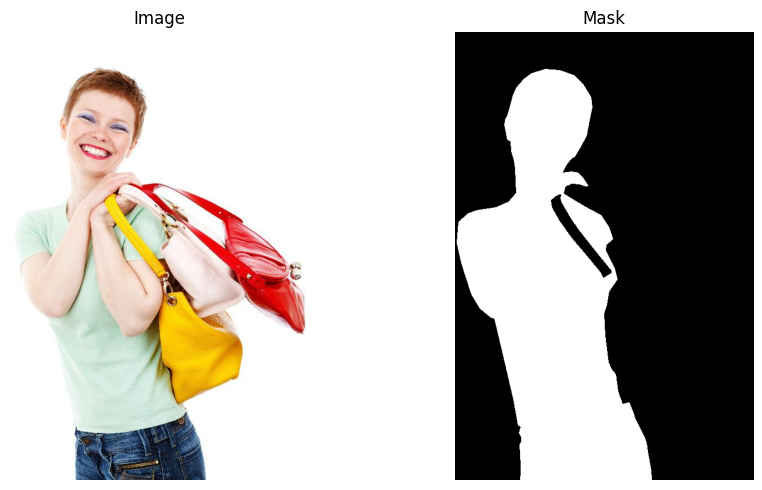

In [27]:
test_data = SegmentationDataset(dataset)

img = test_data[10]

print(f"Image shape: {img[0].shape}")
print(f"Mask shape: {img[1].shape}")

print(f"Image dtype: {img[0].dtype}")
print(f"Mask dtype: {img[1].dtype}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0])
ax[0].set_title("Image")
ax[0].set_axis_off()

ax[1].imshow(img[1], cmap="gray")
ax[1].set_title("Mask")
ax[1].set_axis_off()

plt.tight_layout()
plt.show()

# Traing Pipeline

In [28]:
def traning_fn(loader, model, optimizer, loss_fn, scaler):
  model.train()
  loop = tqdm(loader)
  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    # Forward pass
    with torch.amp.autocast(device_type=DEVICE):
      predictions = model(data)
      loss = loss_fn(predictions, targets)

    # Backward pass
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # Update tqdm loop
    loop.set_postfix(loss=loss.item())


In [29]:
def main():
  train_transform = A.Compose(
      [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
      ],
  )

  val_transform = A.Compose(
      [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
      ],
  )

  model = UNet(in_channels=3, out_channels=1).to(DEVICE)
  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  # Load Dataset
  train_dataset = SegmentationDataset(train_paths, transform=train_transform)
  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=TRAIN_DATA_SHUFFLE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

  val_dataset = SegmentationDataset(val_paths, transform=val_transform)
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

  test_dataset = SegmentationDataset(test_paths, transform=val_transform)
  test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

  print(f"Train batch size: {len(train_dataloader)}")
  print(f"Val batch size: {len(val_dataloader)}")
  print(f"Test batch size: {len(test_dataloader)}\n")

  if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

  scaler = torch.amp.GradScaler(device=DEVICE)

  for epoch in range(NUM_EPOCHS):
    # Train Model
    traning_fn(train_dataloader, model, optimizer, loss_fn, scaler)

    # Save Model
    if SAVE_MODEL and epoch % 2 == 0:
      checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
      }
      save_checkpoint(checkpoint, CHECKPOINT)

    # Check Accuracy
    if CHECK_ACCURACY:
      check_accuracy(val_dataloader, model, device=DEVICE)

    # Check Validation
    if CHECK_VALIDATION_LOSS:
      validation_loss = val_loss(val_dataloader, model, loss_fn, device=DEVICE) # Renamed local variable
      print(f"Validation loss: {validation_loss}") # Moved print statement inside the if block

    save_predictions_as_imgs(val_dataloader, model, folder="saved_images/", device=DEVICE)

In [30]:
main()

Train batch size: 284
Val batch size: 178
Test batch size: 178



100%|██████████| 284/284 [01:22<00:00,  3.44it/s, loss=0.37]


💾 Saving checkpoint
Accuracy: 84.49%
Dice score: 0.5970
Validation loss: 0.36081334488110595


100%|██████████| 284/284 [01:27<00:00,  3.25it/s, loss=0.296]


Accuracy: 85.56%
Dice score: 0.5615
Validation loss: 0.32221321050035817


100%|██████████| 284/284 [01:27<00:00,  3.23it/s, loss=0.269]


💾 Saving checkpoint
Accuracy: 84.72%
Dice score: 0.6199
Validation loss: 0.34066182441925735


In [31]:
# !rm -r "/content/saved_images"